In [377]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import numpy as np 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit 
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from prophet import Prophet

In [378]:
btc = yf.Ticker('BTC-USD')
ltc = yf.Ticker('LTC-USD')
eth = yf.Ticker('ETH-USD')

btc_hist = btc.history(period='max')
ltc_hist = ltc.history(period='max')
eth_hist = eth.history(period='max')

btc_hist['Coin'] = 'BTC'
ltc_hist['Coin'] = 'LTC'
eth_hist['Coin'] = 'ETH'

In [379]:
btc_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Coin
Date,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0,BTC
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0,BTC
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0,BTC
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0,BTC
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0,BTC


In [380]:
eth_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Coin
Date,,,,,,,,
2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,0.0,0.0,ETH
2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,0.0,0.0,ETH
2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,0.0,0.0,ETH
2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,0.0,0.0,ETH
2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,0.0,0.0,ETH


In [381]:
ltc_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Coin
Date,,,,,,,,
2014-09-17 00:00:00+00:00,5.08589,5.17077,4.96595,5.05855,3071840,0.0,0.0,LTC
2014-09-18 00:00:00+00:00,5.06543,5.06543,4.57996,4.68523,4569260,0.0,0.0,LTC
2014-09-19 00:00:00+00:00,4.68729,4.75582,4.25435,4.32777,3917450,0.0,0.0,LTC
2014-09-20 00:00:00+00:00,4.32920,4.61608,4.20219,4.28644,5490660,0.0,0.0,LTC
2014-09-21 00:00:00+00:00,4.26307,4.30013,4.15499,4.24592,2931220,0.0,0.0,LTC


In [382]:
print('Bitcoin Dataset Info: ')
print(btc_hist.info())
print('\nLitecoin Dataset Info: ')
print(ltc_hist.info())
print('\nEthereum Dataset Info: ')
print(eth_hist.info())

Bitcoin Dataset Info: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3865 entries, 2014-09-17 00:00:00+00:00 to 2025-04-16 00:00:00+00:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3865 non-null   float64
 1   High          3865 non-null   float64
 2   Low           3865 non-null   float64
 3   Close         3865 non-null   float64
 4   Volume        3865 non-null   int64  
 5   Dividends     3865 non-null   float64
 6   Stock Splits  3865 non-null   float64
 7   Coin          3865 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 271.8+ KB
None

Litecoin Dataset Info: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3865 entries, 2014-09-17 00:00:00+00:00 to 2025-04-16 00:00:00+00:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3865 non-null   float64
 1   High       

In [383]:
print(btc_hist.isna().sum(), end='\n\n')
print(ltc_hist.isna().sum(), end='\n\n')
print(eth_hist.isna().sum())

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Coin            0
dtype: int64

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Coin            0
dtype: int64

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Coin            0
dtype: int64


## coin_data Dataset

In [384]:
coin_data = pd.concat([btc_hist, ltc_hist, eth_hist]).sort_index()
coin_data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Coin
Date,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0,BTC
2014-09-17 00:00:00+00:00,5.085890,5.170770,4.965950,5.058550,3071840,0.0,0.0,LTC
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0,BTC
2014-09-18 00:00:00+00:00,5.065430,5.065430,4.579960,4.685230,4569260,0.0,0.0,LTC
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0,BTC


In [385]:
coin_data['Coin'] = coin_data['Coin'].astype('category')
coin_data['Coin_Code'] = coin_data['Coin'].cat.codes
coin_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Coin,Coin_Code
Date,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0,BTC,0
2014-09-17 00:00:00+00:00,5.085890,5.170770,4.965950,5.058550,3071840,0.0,0.0,LTC,2
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0,BTC,0
2014-09-18 00:00:00+00:00,5.065430,5.065430,4.579960,4.685230,4569260,0.0,0.0,LTC,2
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0,BTC,0


In [386]:
coin_data['Coin'].unique()

['BTC', 'LTC', 'ETH']
Categories (3, object): ['BTC', 'ETH', 'LTC']

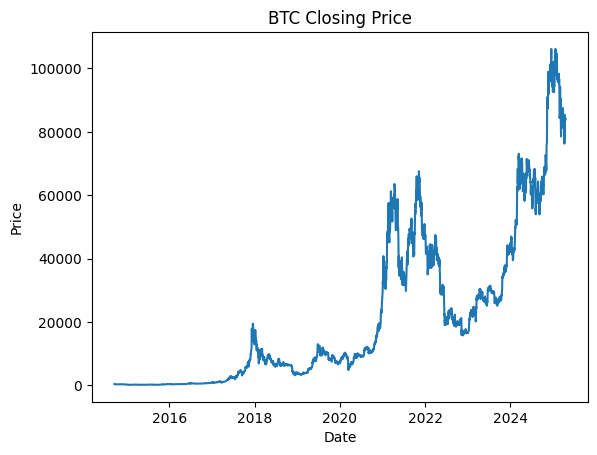

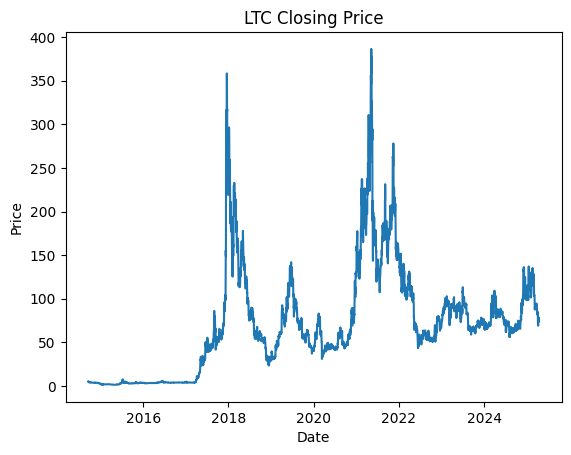

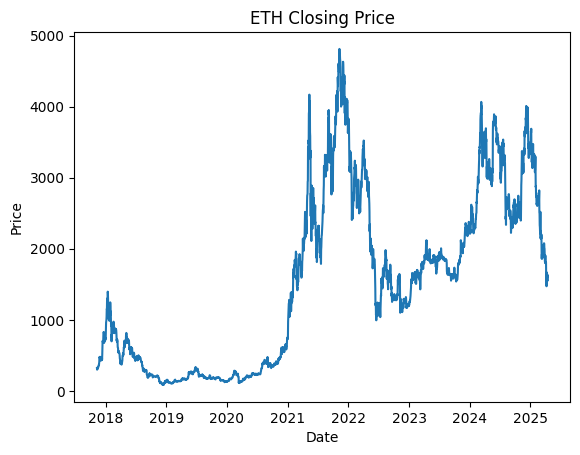

In [387]:
sns.lineplot(data=coin_data[coin_data['Coin'] =='BTC']['Close'])
plt.title('BTC Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
sns.lineplot(data=coin_data[coin_data['Coin'] =='LTC']['Close'])
plt.title('LTC Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
sns.lineplot(data=coin_data[coin_data['Coin'] =='ETH']['Close'])
plt.title('ETH Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [388]:
coin_data['Dividends'].unique(), coin_data['Stock Splits'].unique()

(array([0.]), array([0.]))

In [389]:
coin_data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

In [390]:
coin_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Coin', 'Coin_Code'], dtype='object')

In [391]:
coin_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Coin         0
Coin_Code    0
dtype: int64

In [392]:
# coin_data = coin_data[['Close', 'Volume', 'Coin', 'Coin_Code']]

In [393]:
coin_coded_data = coin_data[[x for x in coin_data.columns if x not in ['Coin']]]
coin_coded_data.head()

,Open,High,Low,Close,Volume,Coin_Code
Date,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0
2014-09-17 00:00:00+00:00,5.085890,5.170770,4.965950,5.058550,3071840,2
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0
2014-09-18 00:00:00+00:00,5.065430,5.065430,4.579960,4.685230,4569260,2
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0


In [394]:
def split_data(df, split_date=None, split_ratio=0.8):
    df.sort_index(inplace=True)

    if split_date is None:
        split_date = df.index[int(len(df) * split_ratio)]

    train = df[df.index < split_date]
    test = df[df.index >= split_date]
    return train, test

def scale_data(train, test):
    # selected_cols = ['Close', 'Volume']  
    selected_cols = train.columns[train.columns != 'Coin_Code']
    train_ = train[selected_cols]
    test_ = test[selected_cols]
    scaler = MinMaxScaler()
    train_scaled_values = scaler.fit_transform(train_)
    test_scaled_values = scaler.transform(test_)
    train_scaled = pd.DataFrame(train_scaled_values, columns=selected_cols, index=train.index)
    test_scaled = pd.DataFrame(test_scaled_values, columns=selected_cols, index=test.index)

    train_scaled['Coin_Code'] = train['Coin_Code']
    test_scaled['Coin_Code'] = test['Coin_Code']

    return train_scaled, test_scaled, scaler



In [395]:
train, test = split_data(coin_coded_data, split_ratio=0.9)
train_scale, test_scale, scaler = scale_data(train, test)
train_scale.shape, test_scale.shape

((9399, 6), (1047, 6))

In [396]:
train_scale.head()

,Open,High,Low,Close,Volume,Coin_Code
Date,,,,,,
2014-09-17 00:00:00+00:00,0.006359,0.006330,0.006327,0.006242,0.000059,0
2014-09-17 00:00:00+00:00,0.000054,0.000052,0.000054,0.000053,0.000007,2
2014-09-18 00:00:00+00:00,0.006236,0.006177,0.005776,0.005792,0.000097,0
2014-09-18 00:00:00+00:00,0.000054,0.000050,0.000049,0.000048,0.000012,2
2014-09-19 00:00:00+00:00,0.005788,0.005783,0.005375,0.005386,0.000107,0


In [397]:
def create_sequences(df, seq_len=30):
    sequences = []
    targets = []
    coin_ids = []
    
    for coin, coin_df in df.groupby('Coin_Code'):
        coin_df = coin_df.sort_index()
        values = coin_df[['Open', 'High', 'Low', 'Close', 'Volume']].values
        
        for i in range(len(values) - seq_len):
            seq_x = values[i:i+seq_len]
            target_y = values[i+seq_len][0] 
            sequences.append(seq_x)
            targets.append(target_y)
            coin_ids.append(coin)
    
    return np.array(sequences), np.array(targets), np.array(coin_ids)


In [398]:
X_train, y_train, coin_ids = create_sequences(train_scale, seq_len=60)
X_test, y_test, coin_ids_test = create_sequences(test_scale, seq_len=60)
X_train.shape, y_train.shape, coin_ids.shape, X_test.shape, y_test.shape, coin_ids_test.shape

((9219, 60, 5), (9219,), (9219,), (867, 60, 5), (867,), (867,))

In [399]:
counts = pd.Series(coin_ids).value_counts()
print(counts)

0    3456
2    3456
1    2307
Name: count, dtype: int64


In [400]:
pd.Series(coin_ids_test).value_counts()

0    289
1    289
2    289
Name: count, dtype: int64

In [401]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 5)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [402]:
# early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [403]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    shuffle=False
    # callbacks=[early_stop]
)

Epoch 1/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0033 - mean_absolute_error: 0.0300 - val_loss: 0.0747 - val_mean_absolute_error: 0.1610
Epoch 2/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0199 - val_loss: 0.0372 - val_mean_absolute_error: 0.1128
Epoch 3/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0010 - mean_absolute_error: 0.0181 - val_loss: 0.1465 - val_mean_absolute_error: 0.2244
Epoch 4/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0010 - mean_absolute_error: 0.0177 - val_loss: 7.2264e-04 - val_mean_absolute_error: 0.0134
Epoch 5/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 6.1583e-04 - mean_absolute_error: 0.0120 - val_loss: 0.0213 - val_mean_absolute_error: 0.0821
Epoch 6/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 8.9217e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0778 - val_mean_absolute_error: 0.1632
Epoch 7/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 8.2707e-04 - mean_abs

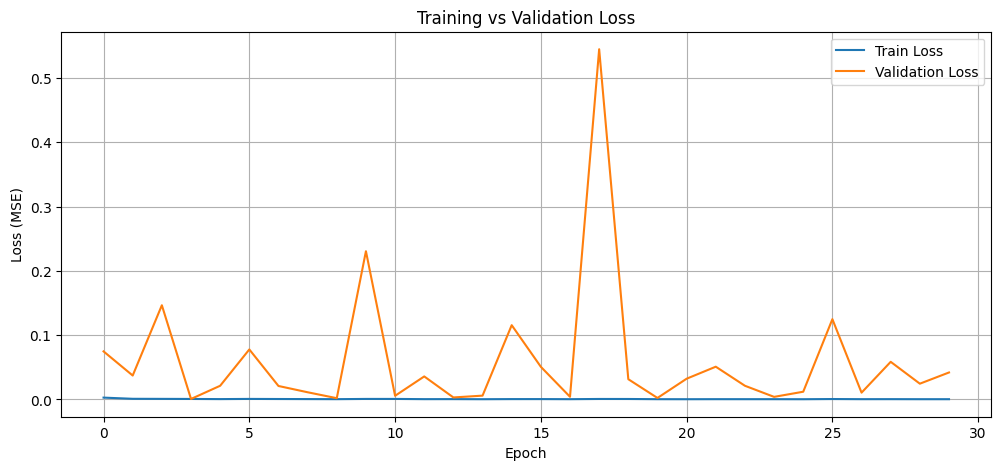

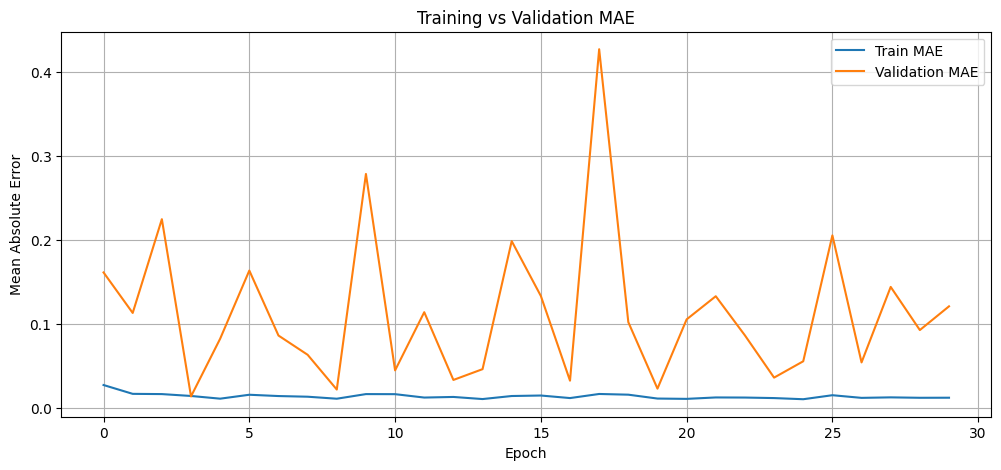

In [404]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# MAE
plt.figure(figsize=(12, 5))
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()


In [405]:
X_test.shape

(867, 60, 5)

In [406]:
def prediction(model, X_test, y_test):
    predicted = model.predict(X_test)

    def expand_for_inverse(scaled_close, total_features=5, target_col=3):
        expanded = np.zeros((scaled_close.shape[0], total_features))
        expanded[:, target_col] = scaled_close.flatten()
        return expanded

    predicted_expanded = expand_for_inverse(predicted)
    real_expanded = expand_for_inverse(y_test)

    predicted_full = scaler.inverse_transform(predicted_expanded)
    real_full = scaler.inverse_transform(real_expanded)

    predicted_close = predicted_full[:, 3]
    real_close = real_full[:, 3]
    return predicted_close, real_close


In [407]:
def evaluate_model(y_true, y_pred, model_name='Model'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Evaluation")
    print(f"MSE : {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE : {mae}")
    print(f"R²  : {r2}")

In [408]:
predicted_close, real_close = prediction(model, X_test, y_test)
evaluate_model(real_close, predicted_close, model_name='LSTM-1')

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
LSTM-1 Evaluation
MSE : 224007449.29440272
RMSE: 14966.878408485944
MAE : 8818.729157576003
R²  : 0.8443930803704811


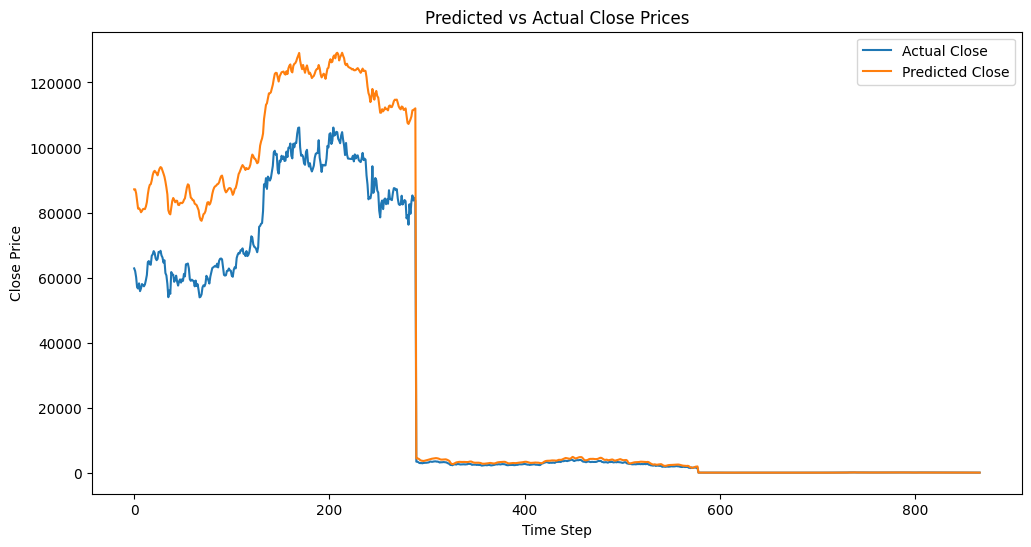

In [409]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(real_close, label="Actual Close")
plt.plot(predicted_close, label="Predicted Close")
plt.title("Predicted vs Actual Close Prices")
plt.xlabel("Time Step")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [410]:

model_list_lstm = [
    [
        LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], 5)),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dense(units=1)],
    [
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 5)),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dense(units=1)
    ],
    [
        LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 5)),
        Dropout(0.2),
        LSTM(128, return_sequences=False),
        Dense(units=1)
    ],
    [
        LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], 5)),
        Dropout(0.2),
        LSTM(32, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dense(units=1)
    ],
    [
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 5)),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dense(units=1)
    ],
    [
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 5)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ]
]

In [411]:
best_model = None
best_history = None
best_val_loss = float('inf')
best_index = -1

histories = []

for i, arch in enumerate(model_list_lstm):
    print(f"\n Training model {i+1}/{len(model_list_lstm)}...")

    model = Sequential()
    for layer in arch:
        model.add(layer)

    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    # early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_test, y_test),
        shuffle=False,
        verbose=0
    )

    val_loss = min(history.history['val_loss'])
    histories.append((model, history))

    print(f" Model {i+1} best val_loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_history = history
        best_index = i

print(f"\n Best model is Model {best_index+1} with val_loss: {best_val_loss:.4f}")



 Training model 1/6...
 Model 1 best val_loss: 0.0020

 Training model 2/6...
 Model 2 best val_loss: 0.0006

 Training model 3/6...
 Model 3 best val_loss: 0.0005

 Training model 4/6...
 Model 4 best val_loss: 0.0057

 Training model 5/6...
 Model 5 best val_loss: 0.0029

 Training model 6/6...
 Model 6 best val_loss: 0.0007

 Best model is Model 3 with val_loss: 0.0005


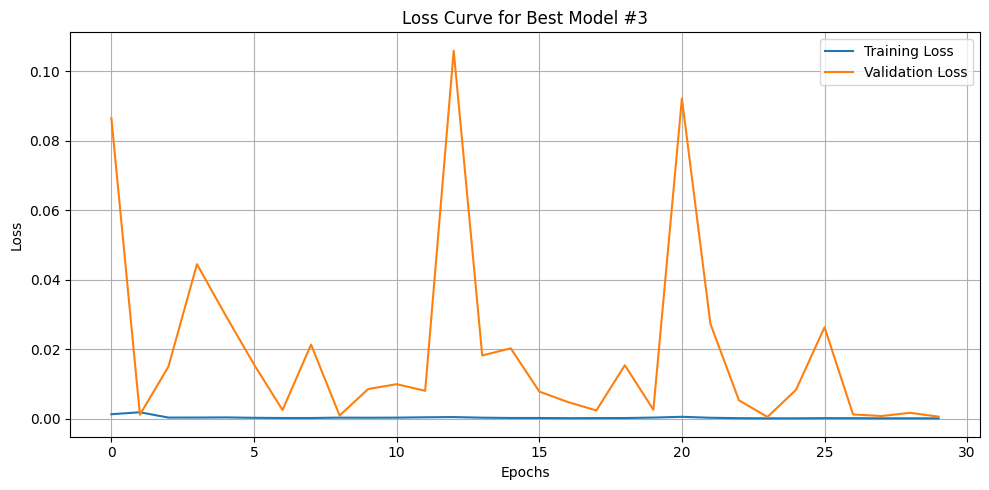

In [412]:
plt.figure(figsize=(10, 5))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss Curve for Best Model #{best_index+1}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [413]:
X_test.shape, y_test.shape, coin_ids_test.shape

((867, 60, 5), (867,), (867,))

## Test datasets

In [414]:
X_train, y_train, coin_ids = create_sequences(train_scale, seq_len=60)
X_test, y_test, coin_ids_test = create_sequences(test_scale, seq_len=60)
X_train.shape, y_train.shape, coin_ids.shape, X_test.shape, y_test.shape, coin_ids_test.shape

# bitcoin
btc_mask = coin_ids_test == 0
X_test_btc = X_test[btc_mask]
y_test_btc = y_test[btc_mask]

# litecoin
ltc_mask = coin_ids_test == 1
X_test_ltc = X_test[ltc_mask]
y_test_ltc = y_test[ltc_mask]

# ethereum
eth_mask = coin_ids_test == 2
X_test_eth = X_test[eth_mask]
y_test_eth = y_test[eth_mask]

# Equal 
min_count = min(np.sum(btc_mask), np.sum(eth_mask), np.sum(ltc_mask))

btc_indices = np.where(btc_mask)[0][:min_count]
eth_indices = np.where(eth_mask)[0][:min_count]
ltc_indices = np.where(ltc_mask)[0][:min_count]

equal_indices = np.concatenate([btc_indices, eth_indices, ltc_indices])

X_test_equal = X_test[equal_indices]
y_test_equal = y_test[equal_indices]

# Random 
np.random.seed(42)
rand_indices = np.random.choice(len(X_test), size=250, replace=False)

X_test_random = X_test[rand_indices]
y_test_random = y_test[rand_indices]

x_test_sets = [X_test_btc, X_test_ltc, X_test_eth, X_test_equal, X_test_random]
y_test_sets = [y_test_btc, y_test_ltc, y_test_eth, y_test_equal, y_test_random]
x_test_names = ['BTC', 'LTC', 'ETH', 'Equal', 'Random']
 
for i in range(len(x_test_sets)):
    print(f"X_test_{x_test_names[i]} shape: {x_test_sets[i].shape}")



X_test_BTC shape: (289, 60, 5)
X_test_LTC shape: (289, 60, 5)
X_test_ETH shape: (289, 60, 5)
X_test_Equal shape: (867, 60, 5)
X_test_Random shape: (250, 60, 5)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
BTC Evaluation
MSE : 9003706.438649874
RMSE: 3000.617676187667
MAE : 2577.1282861947016
R²  : 0.966428778519307


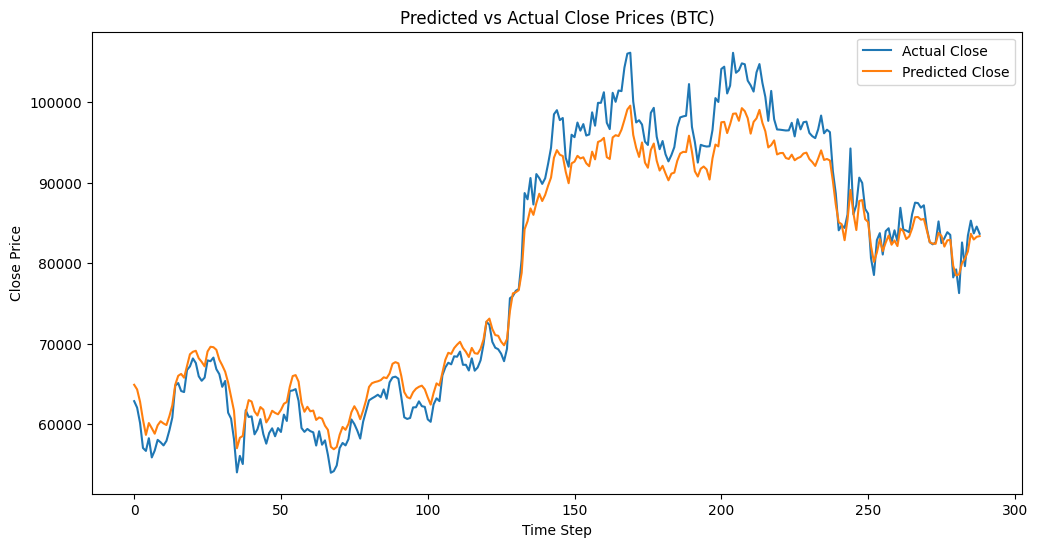

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LTC Evaluation
MSE : 7017.1646050518475
RMSE: 83.76851798290242
MAE : 64.90215196686519
R²  : 0.9791189327648705


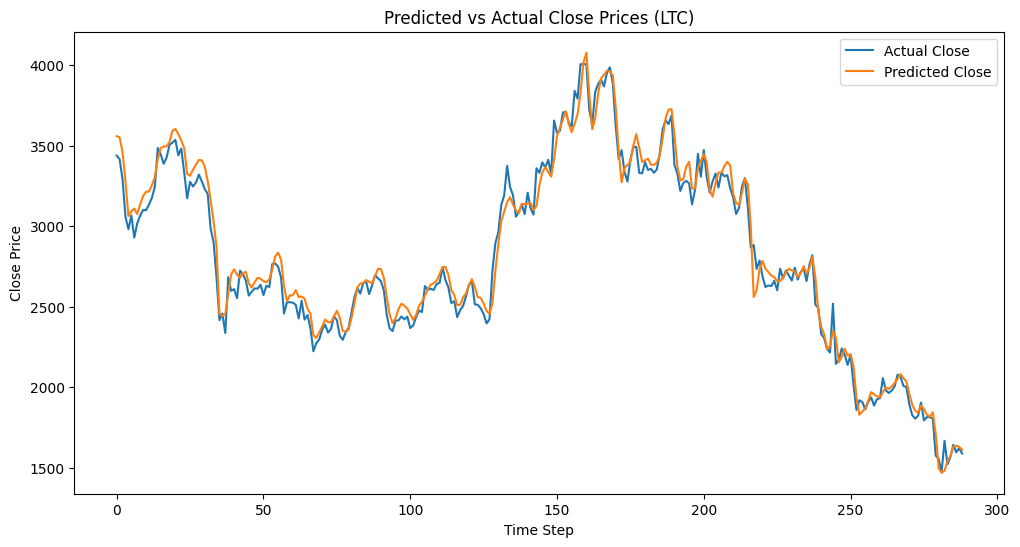

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
ETH Evaluation
MSE : 34.00387332071793
RMSE: 5.831284019898013
MAE : 4.694178953761527
R²  : 0.9347081214683


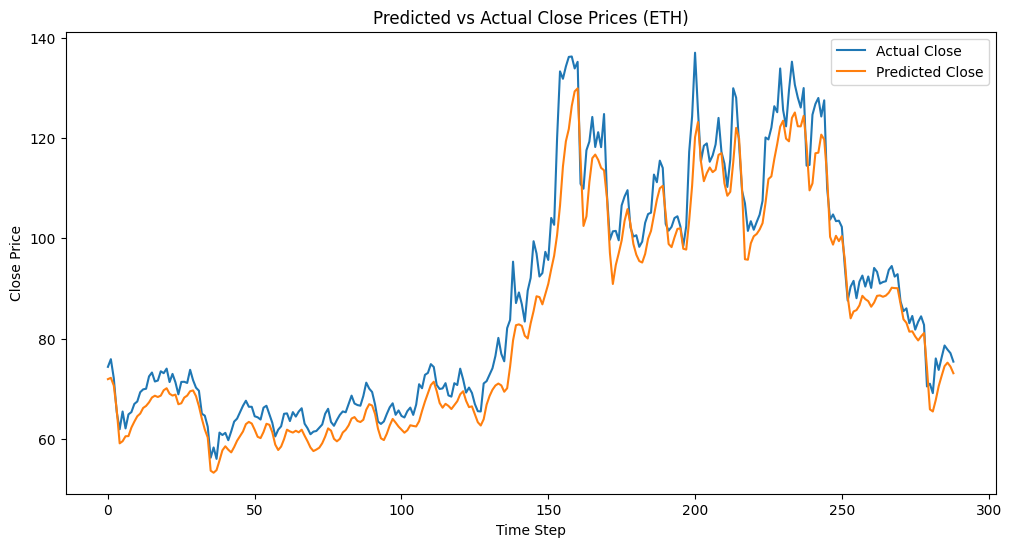

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Equal Evaluation
MSE : 3003585.880789076
RMSE: 1733.085653044614
MAE : 882.2415591355457
R²  : 0.9979135571239952


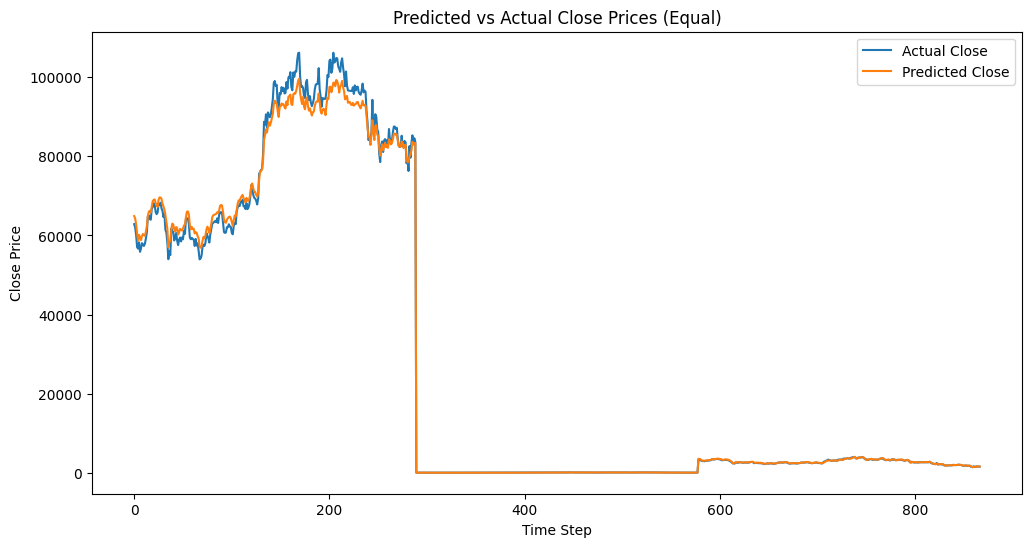

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Random Evaluation
MSE : 3026461.3575357837
RMSE: 1739.6727731202163
MAE : 845.3614629429094
R²  : 0.9977047406498362


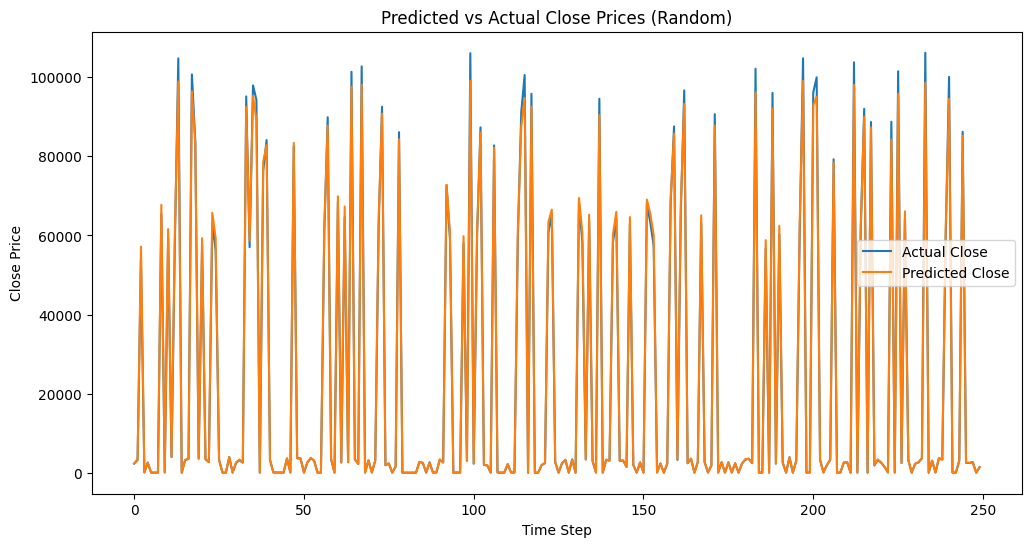

In [415]:
x_test_sets = [X_test_btc, X_test_ltc, X_test_eth, X_test_equal, X_test_random]
y_test_sets = [y_test_btc, y_test_ltc, y_test_eth, y_test_equal, y_test_random]
x_test_names = ['BTC', 'LTC', 'ETH', 'Equal', 'Random']

for i in range(len(x_test_sets)):
    x_test = x_test_sets[i]
    y_test = y_test_sets[i]
    
    predicted_close, real_close = prediction(best_model, x_test, y_test)
    evaluate_model(real_close, predicted_close, model_name=x_test_names[i])
    
    plt.figure(figsize=(12,6))
    plt.plot(real_close, label="Actual Close")
    plt.plot(predicted_close, label="Predicted Close")
    plt.title(f"Predicted vs Actual Close Prices ({x_test_names[i]})")
    plt.xlabel("Time Step")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()